> # N-클래스의 로지스틱 회귀

- N-클래스의 경우에도 scikit-learn을 사용하면 비슷한 형태로 수행 가능
___
 > ## scikit-learn으로 3-클래스 식별하기

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs

def plot_boundary(w):
  x = np.arange(-1.0, 1.1, 0.1)
  y = eval('%f*x + %f' % ((-w[1] / (w[2]+1e-6)), (-w[0]/(w[2]+1e-6))))
  plt.plot(x, y, linewidth = 2)
  
  
# scatter plot 함수 (개인 버전)
def plot_scatter():
  sns.lmplot('x0', 'x1', hue = 'y', data = dataset, fit_reg= False)
  plt.ylim(-1, 1)
  plt.xlim(-1,1)

In [6]:
# 본 챕터에서 사용 할 데이터 세트
X_dataset, y_dataset = make_blobs(centers=[[-0.4,0.6],
                                          [0.5, 0.4],
                                          [-0.1, -0.5]],
                                  cluster_std=0.1,
                                  n_samples=150,
                                  center_box=(-1.0, 1.0),
                                  random_state=42)

dataset = pd.DataFrame(X_dataset, columns = ['x0', 'x1'])
dataset['y'] = y_dataset

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


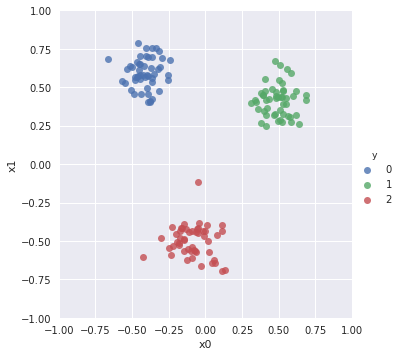

In [9]:
plot_scatter()

- 위와 같이 [0, 1, 2] 클래스로 구성된 데이터가 있음
- 똑같이 `sklearn.liner_model`의 `LogisticRegression()`을 사용해서 학습 가능함
- 원래 `multi_class = 'ovr'`이 매개변수 기본값으로 세팅되어 있으나, 아래의 경우 명시적으로 입력 해 봄

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
classifier = LogisticRegression(multi_class = 'ovr')

classifier.fit(X_dataset, y_dataset)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

- 이 경우 식별경계는 수식으로 표현하기 어려움
- 대신, `meshgrid`를 사용하여 -1부터 1까지 0.01 간격으로 점들을 생성하고, `plt.contour`로 등고선을 그려 경계를 표현

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


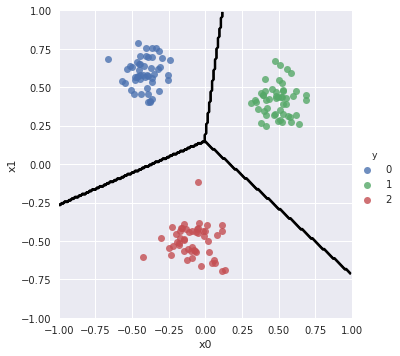

In [14]:
plot_scatter()

# 0.01 간격의 그리드 만들기
xx, yy = np.meshgrid(np.arange(-1.0, 1.0, 0.01),
                    np.arange(-1.0, 1.0, 0.01))

# 생성한 그리드의 점을 하나하나 추론하기
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])    # ravel()은 2차원 객체를 1차원으로 변환해 주고, np.c_는 두 1차원 벡터를 열단위 병합

# 그래프를 그릴 수 있게 2차원 배열로 변환
Z = Z.reshape(xx.shape)

# 식별 경계 그리기
plt.contour(xx, yy, Z, colors = 'k')

> # one-vs-rest
- 위에서 `multi_class = 'ovr`로 매개변수를 설정한 것은 "one-vs-rest"의 약자임
- 1대 나머지라는 의미로 하나씩 클래스를 구분 짓는 식별기를 생성해서 조합하는 방법임
- 예를 들어 본 예제는 아래 각각의 클래스를 하나씩 만든 후 조합하는 방법으로 식별 경계를 만듦:  
    클래스 0 vs 클래스 1, 2  
    클래스 1 vs 클래스 0, 2  
    클래스 2 vs 클래스 0, 1
 - ovr 식별경계를 그려보면 다음과 같이 표현 가능

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


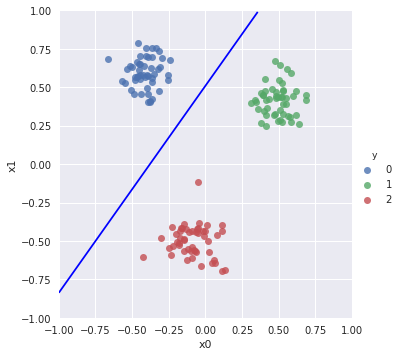

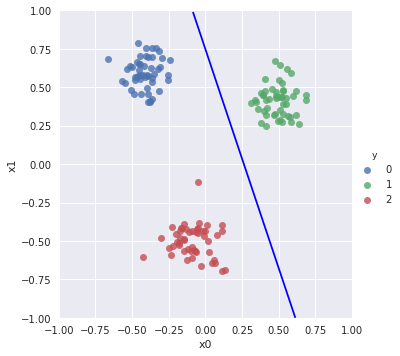

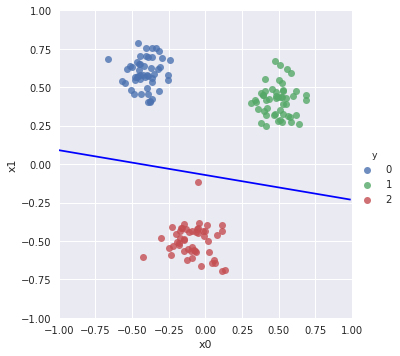

In [23]:
for one in range(3):
  plot_scatter()
  # 0.01 간격의 그리드 만들기
  xx, yy = np.meshgrid(np.arange(-1.0, 1.0, 0.01),
                      np.arange(-1.0, 1.0, 0.01))

  # 생성한 그리드의 점을 하나하나 추론하기
  Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])

  # 2차원 배열로 변환
  Zone = Z[:, one].reshape(xx.shape)
  plt.contour(xx, yy, Zone, colors = 'b', levels = [0])

___
> ## 2-클래스를 N-클래스 식별로 변경하기

- 3개의 식별경계를 합치는 방법은 **"3개의 식별 경계로부터 거리가 가장 큰 것"**을 선택하게 만드는 방식으로 구현
- 클래스 2와 나머지의 식별 경계와 그 정도를 보면 아래와 같이 표현 가능

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


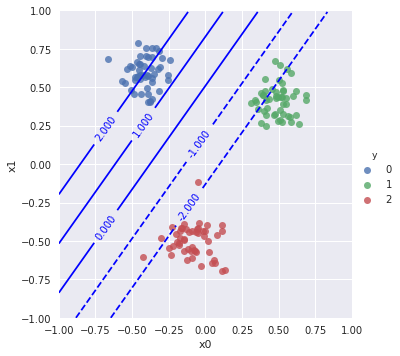

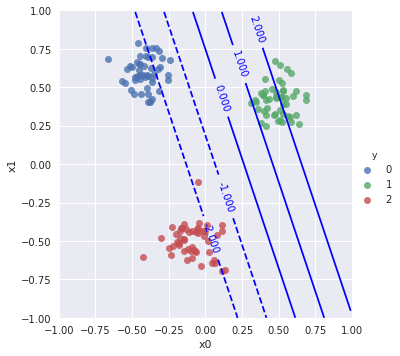

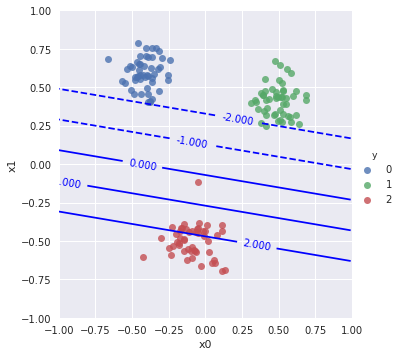

In [25]:
for one in range(3):
  plot_scatter()
  
  xx, yy = np.meshgrid(np.arange(-1.0, 1.0, 0.01),
                      np.arange(-1.0, 1.0, 0.01))

  # 생성한 그리드의 점을 하나하나 추론하기
  Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Zone = Z[:, one].reshape(xx.shape)
  
  cs = plt.contour(xx, yy, Zone, colors = 'b', levels = [-2, -1, 0, 1, 2])
  plt.clabel(cs, inline= 1, fontsize = 10)  # clabel은 등고선의 값을 반환

- 값이 양의 방향으로 갈 수록 해당 점은 "one" 클래스일 확률이 높으며, 음의 방향일수록 "rest' 클래스일 확률이 높아짐
- 예를 들어 (-0.5, 0.5)인 점이 있다면 클래스 0은 2,000 근처, 나머지는 -2,000보다 작은 위치게 있게되어 0으로 확정됨
- 위 그림을 한꺼번에 그래프에 그리면 다음과 같이 구현 가능

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


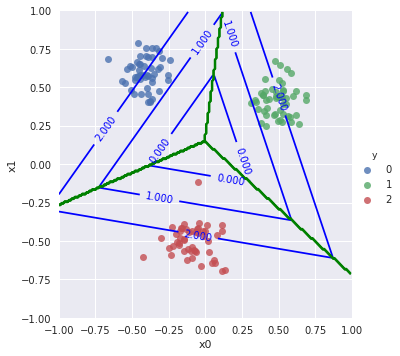

In [33]:
# 0.01간격의 그리드 만들기  
xx, yy = np.meshgrid(np.arange(-1.0, 1.0, 0.01),
                    np.arange(-1.0, 1.0, 0.01))

# 그리드의 점을 하나씩 추론
Zp = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Zp = Zp.reshape(xx.shape)

Zd = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])

plot_scatter()
for one in range(3):
  # 각 클래스에 해당하는 점 추출 (지정 조건에 해당하는 데이터를 마스크 해 두는 기능)
  Zone = np.ma.array(Zd[:, one].reshape(xx.shape), mask = (Zp != one))
  
  # 식별 경계로부터 거리 구하고 등고선 그리기
  cs = plt.contour(xx, yy, Zone, colors = 'b', levels = [0, 1, 2])
  plt.clabel(cs, inline = 1, fontsize = 10)

# 식별 경계 그리기
plt.contour(xx, yy, Zp, colors = 'g')

___
> ## 다른 N-클래스 해결방법

- "one-vs-rest" 외에 "one-vs-one 방식으로도 문제 해결 가능
- [A, B, C, D]를 분류하는데 있어 ovr은 4 조합으로 해결
- ovo의 경우 1:1로 모든 조합을 생성하여 6 종류로 식별 [[A,B], [A,C], [A,D], [B,C], [B,C], [C,D]]
- 당연히 조합 수가 늘어나는 만큼 "one-vs-one'이 더 오랜 시간 소요